## Import Dependencies

In [38]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Wedge
from mplsoccer import Pitch


## Data Preprocessing

In [3]:
# 12 rows x 16 columns grid
XT_GRID = np.array([
    [0.001, 0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.009, 0.011, 0.013, 0.016, 0.017, 0.017, 0.016],
    [0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.015, 0.018, 0.021, 0.020, 0.021],
    [0.002, 0.003, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.009, 0.010, 0.013, 0.016, 0.021, 0.025, 0.027, 0.024],
    [0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.014, 0.018, 0.024, 0.029, 0.039, 0.031],
    [0.003, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.011, 0.014, 0.019, 0.027, 0.055, 0.091, 0.071],
    [0.004, 0.004, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.014, 0.019, 0.033, 0.077, 0.142, 0.332],
    [0.004, 0.004, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.012, 0.014, 0.020, 0.034, 0.085, 0.134, 0.320],
    [0.004, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.010, 0.012, 0.014, 0.020, 0.028, 0.062, 0.095, 0.085],
    [0.002, 0.003, 0.004, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.014, 0.018, 0.025, 0.035, 0.042, 0.033],
    [0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.011, 0.013, 0.017, 0.021, 0.026, 0.026, 0.022],
    [0.002, 0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.007, 0.009, 0.010, 0.013, 0.016, 0.019, 0.021, 0.020, 0.020],
    [0.001, 0.002, 0.002, 0.003, 0.004, 0.004, 0.005, 0.007, 0.008, 0.009, 0.012, 0.014, 0.016, 0.018, 0.017, 0.017]
])

# Pitch Dimensions
SB_WIDTH = 120
SB_HEIGHT = 80
ROWS, COLS = XT_GRID.shape

In [4]:
def _load_events_raw(match_id, base_path):
    event_path = os.path.join(base_path, f"events/{match_id}.json")
    with open(event_path, "r") as f:
        events_raw = json.load(f)
    return events_raw

In [5]:
def _extract_shot_features(df_events):
    df_shots = df_events[df_events["type_name"] == "Shot"].copy()
    
    if not df_shots.empty:
        target_cols = {
            'id': 'shot_id_temp',
            'shot_statsbomb_xg': 'assisted_shot_xg',
            'shot_outcome_name': 'assisted_shot_outcome'
        }
        return df_shots[list(target_cols.keys())].rename(columns=target_cols)
    
    # Return empty structure if no shots found
    return pd.DataFrame(columns=['shot_id_temp', 'assisted_shot_xg', 'assisted_shot_outcome'])

The function `load_passes` serves as a standardized processing engine to convert raw StatsBomb JSON events into an analysis-ready format. It follows a multi-stage pipeline designed for modularity and future research extensibility.

| **Stage** | **Process** | **Research Utility** |
|---|---|---|
| Feature Extraction | Isolate "Pass" events and utilize a helper function to retrieve associated Shot xG and outcomes. | Allows for "Pass-to-Shot" dependency analysis and Shot-Assist quality metrics. |
| Attribute Filtering | Selects a standardized subset of tactical markers (e.g., `pass_cross`, `pass_technique_name`). | Maintains a lightweight DataFrame while preserving latent variables for future categorical analysis. |
| Coordinate Normalization | Unpacks nested location lists into discrete (x,y) and (end_x,end_y) vectors. | Essential for heatmapping, distance calculations, and geometric formation analysis. |
| Spatial Threat Mapping | Vectorized lookup against a 12x16 xT Matrix to calculate the Threat Delta (ΔxT). | Quantifies the progressive value of possession beyond traditional completion percentages. |

In [6]:
def load_passes(match_id, base_path):
    events_raw = _load_events_raw(match_id, base_path)
    df_events = pd.json_normalize(events_raw, sep="_")
    
    # Extract and Format Shot Data 
    df_shots = _extract_shot_features(df_events)

    # Filter Passes & Select Columns
    df_passes = df_events[df_events["type_name"] == "Pass"].copy()
    
    desired_columns = [
        "id", "period", "timestamp", "minute", "second","team_name", "player_id", "player_name", 
        "pass_recipient_id", "pass_recipient_name", "location", "pass_end_location",
        "pass_length", "pass_angle", "pass_height_name", "pass_assisted_shot_id", 
        "pass_backheel", "pass_deflected", "pass_miscommunication", "pass_cross", 
        "pass_cut_back", "pass_switch", "pass_shot_assist", "pass_goal_assist", 
        "pass_body_part_name", "pass_type_name", "pass_outcome_name", "pass_technique_name"
    ]
    
    existing_cols = [col for col in desired_columns if col in df_passes.columns]
    df_passes = df_passes[existing_cols].copy()

    # Merges Shots and Passes
    if "pass_assisted_shot_id" in df_passes.columns:
        df_passes = df_passes.merge(df_shots, left_on='pass_assisted_shot_id', right_on='shot_id_temp', how='left').drop(columns=['shot_id_temp'])
    else:
        df_passes[['assisted_shot_xg', 'assisted_shot_outcome']] = None

    # Unpack Coordinates
    if "location" in df_passes.columns:
        df_passes[['x', 'y']] = pd.DataFrame(df_passes['location'].tolist(), index=df_passes.index)
        df_passes[['end_x', 'end_y']] = pd.DataFrame(df_passes['pass_end_location'].tolist(), index=df_passes.index)

    # Calculate Expected Threat (xT)
    if all(col in df_passes.columns for col in ['x', 'y', 'end_x', 'end_y']):
        x_bins = np.clip(np.floor(df_passes['x'] / SB_WIDTH * COLS).astype(int), 0, COLS - 1)
        y_bins = np.clip(np.floor(df_passes['y'] / SB_HEIGHT * ROWS).astype(int), 0, ROWS - 1)
        
        end_x_bins = np.clip(np.floor(df_passes['end_x'] / SB_WIDTH * COLS).astype(int), 0, COLS - 1)
        end_y_bins = np.clip(np.floor(df_passes['end_y'] / SB_HEIGHT * ROWS).astype(int), 0, ROWS - 1)

        start_xt = XT_GRID[y_bins, x_bins]
        end_xt = XT_GRID[end_y_bins, end_x_bins]
        df_passes['pass_xt'] = end_xt - start_xt

    return df_passes

We load lineups to map unique StatsBomb identifiers to descriptive player attributes, ensuring tbetter visualizations. 

In [7]:
def load_lineups(match_id, base_path):
    lineup_path = os.path.join(base_path, f"lineups/{match_id}.json")
    
    with open(lineup_path, "r") as f:
        lineups_raw = json.load(f)
        
    lineup_list = []
    for team in lineups_raw:
        team_name = team["team_name"]
        for player in team["lineup"]:
            player_info = {
                "team_name": team_name,
                "player_id": player["player_id"],
                "player_name": player["player_name"],
                "player_nickname": player.get("player_nickname"),
                "jersey_number": player["jersey_number"],
                "country": player["country"]["name"]
            }
            lineup_list.append(player_info)
            
    df_lineups = pd.DataFrame(lineup_list)
    return df_lineups

In constructing a passing network, the primary objective is to visualize the intended tactical structure of a team. To ensure the integrity of this visualization, we apply a "First Sub" cutoff logic, which restricts the dataset to the period between kick-off and the first structural change (substitution or dismissal).

Therefore, here we made a "chronological governer" of the data. It establishes the timeline of the match to determine exactly when each player was active.

| **Component** | **Logic Applied** |
| --- | --- |
| Starters | Identifies the 22 players in the `Starting XI` events and initializes their start time to 00:00. |
| Substitutions | Triggers a dual update: records the exit time for the player going off and initializes a new entry for the player coming on. |
| Disciplinary Exits | Scans for `Red Card` or `Second Yellow` events to force an early exit time for the penalized player. |
| Match Ceiling | Identifies the final recorded event time to serve as the default exit for all players still on the pitch. |

In [8]:
def load_appearances(match_id, base_path):
    events_raw = _load_events_raw(match_id, base_path)
    df_events = pd.json_normalize(events_raw, sep="_")
    
    # Match End Ceiling
    max_idx = df_events['minute'].idxmax()
    match_end = {
        'minute': df_events.loc[max_idx, 'minute'],
        'second': df_events.loc[max_idx, 'second'],
        'period': df_events.loc[max_idx, 'period'],
        'timestamp': df_events.loc[max_idx, 'timestamp']
    }
    
    appearances = {}
    
    # A: Starters
    starters = df_events[df_events['type_name'] == 'Starting XI']
    match_start_ts = df_events.loc[0, 'timestamp']
    
    for _, event in starters.iterrows():
        raw_event = [e for e in events_raw if e['id'] == event['id']][0]
        for player in raw_event['tactics']['lineup']:
            p_id = player['player']['id']
            appearances[p_id] = {
                'player_name': player['player']['name'],
                'team_name': event['team_name'],
                'start_minute': 0, 'start_second': 0, 'start_period': 1,
                'start_timestamp': match_start_ts,
                'end_minute': match_end['minute'], 'end_second': match_end['second'],
                'end_period': match_end['period'], 'end_timestamp': match_end['timestamp'],
                'status': 'Starter'
            }

    # B: Substitutions
    subs = df_events[df_events['type_name'] == 'Substitution']
    for _, event in subs.iterrows():
        p_off = event['player_id']
        p_in = event['substitution_replacement_id']
        
        # Player OFF: Update End Time
        if p_off in appearances:
            appearances[p_off].update({
                'end_minute': event['minute'], 'end_second': event['second'],
                'end_period': event['period'], 'end_timestamp': event['timestamp']
            })
            
        # Player ON: Create New Entry
        appearances[p_in] = {
            'player_name': event['substitution_replacement_name'],
            'team_name': event['team_name'],
            'start_minute': event['minute'], 'start_second': event['second'],
            'start_period': event['period'], 'start_timestamp': event['timestamp'],
            'end_minute': match_end['minute'], 'end_second': match_end['second'],
            'end_period': match_end['period'], 'end_timestamp': match_end['timestamp'],
            'status': 'Sub'
        }

    # C: Red Cards
    card_cols = ['bad_behaviour_card_name', 'foul_committed_card_name']
    valid_card_cols = [c for c in card_cols if c in df_events.columns]
    
    for col in valid_card_cols:
        reds = df_events[df_events[col].isin(['Red Card', 'Second Yellow'])]
        for _, event in reds.iterrows():
            if event['player_id'] in appearances:
                appearances[event['player_id']].update({
                    'end_minute': event['minute'], 'end_second': event['second'],
                    'end_period': event['period'], 'end_timestamp': event['timestamp']
                })

    # D: Match Ceiling
    df_app = pd.DataFrame.from_dict(appearances, orient='index').reset_index().rename(columns={'index': 'player_id'})
    df_app['mins_played'] = df_app['end_minute'] - df_app['start_minute']
    
    return df_app

In [9]:
def prepare_filtered_passes(base_path, match_id, team_name=None):
    # Load the three core modules
    df_passes = load_passes(match_id, base_path)
    df_app = load_appearances(match_id, base_path)
    df_lineups = load_lineups(match_id, base_path)
    
    #  Resolve Team Name
    if team_name is None:
        team_name = df_lineups['team_name'].unique()[0]
    
    # Identify Starters and their earliest exit time
    mask_starters = (df_app['team_name'] == team_name) & (df_app['status'] == 'Starter')
    df_starters = df_app[mask_starters].copy()
    
    # Create time tuples (Period, Minute, Second) to find the exact cutoff
    df_starters['exit_time_tuple'] = list(zip(
        df_starters['end_period'], 
        df_starters['end_minute'], 
        df_starters['end_second']
    ))
    earliest_exit = df_starters['exit_time_tuple'].min()
    
    # Filter passes by Team, Player ID (Starters), and Time
    starter_ids = df_starters['player_id'].tolist()
    pass_time_tuples = list(zip(df_passes['period'], df_passes['minute'], df_passes['second']))
    is_before_cutoff = [t < earliest_exit for t in pass_time_tuples]
    
    df_passes_clean = df_passes[
        (df_passes['team_name'] == team_name) &
        (df_passes['player_id'].isin(starter_ids)) &
        (pd.Series(is_before_cutoff, index=df_passes.index))
    ].copy()
    
    return df_passes_clean

## Plot the Passing Network

In [10]:
def calculate_average_locations(df_passes_clean):
    # Metric Columns
    df_passes_clean['is_success'] = df_passes_clean['pass_outcome_name'].isna().astype(int)
    df_passes_clean['pass_xt'] = df_passes_clean.get('pass_xt', 0).fillna(0)

    # Main Aggregation
    df_nodes = df_passes_clean.groupby(['player_id', 'player_name']).agg({
        'x': 'mean',
        'y': 'mean',
        'id': 'count',              
        'is_success': 'sum',       
        'pass_xt': 'sum'            
    }).reset_index()

    df_nodes.rename(columns={'id': 'pass_count', 'is_success': 'success_count', 'pass_xt': 'total_xt'}, inplace=True)
    df_nodes['success_rate'] = df_nodes['success_count'] / df_nodes['pass_count']

    # Calculate Average Angle of FAILED Passes
    df_failed = df_passes_clean[df_passes_clean['is_success'] == 0].copy()
    
    if not df_failed.empty:
        # Convert radians to unit vectors (x, y) to handle circular averaging
        df_failed['fail_cos'] = np.cos(df_failed['pass_angle'])
        df_failed['fail_sin'] = np.sin(df_failed['pass_angle'])
        
        # Group by player and average the vectors
        fail_dirs = df_failed.groupby('player_id')[['fail_cos', 'fail_sin']].mean()
        
        # Convert back to degrees (StatsBomb 0 is East, 90 is North - matches MPL)
        fail_dirs['avg_fail_angle'] = np.degrees(np.arctan2(fail_dirs['fail_sin'], fail_dirs['fail_cos']))
        
        # Merge back to nodes
        df_nodes = df_nodes.merge(fail_dirs['avg_fail_angle'], on='player_id', how='left')
    else:
        df_nodes['avg_fail_angle'] = 0 # Default if match has 0 errors (rare)

    # Fill NaN angles (players with 100% success have no fail angle) with 0
    df_nodes['avg_fail_angle'] = df_nodes['avg_fail_angle'].fillna(0)
    
    return df_nodes

In [ ]:
def calculate_edges_asymmetric(df_passes_clean):
    # Get raw directional counts
    df_dir = df_passes_clean.groupby(['player_id', 'pass_recipient_id']).size().reset_index(name='count')
    
    # Create a unique key for the pair regardless of direction
    df_dir['pair_key'] = df_dir.apply(lambda x: tuple(sorted([int(x['player_id']), int(x['pass_recipient_id'])])), axis=1)
    
    pairs = []
    # Iterate through each unique pair to aggregate both directions
    for key, group in df_dir.groupby('pair_key'):
        if len(key) < 2: continue
        p1_id, p2_id = key
        
        v_1_to_2 = group[(group['player_id'] == p1_id) & (group['pass_recipient_id'] == p2_id)]['count'].sum()
        v_2_to_1 = group[(group['player_id'] == p2_id) & (group['pass_recipient_id'] == p1_id)]['count'].sum()
        
        if (v_1_to_2 + v_2_to_1) >= 3:
            pairs.append({
                'p1_id': p1_id,
                'p2_id': p2_id,
                'v_1_to_2': v_1_to_2,
                'v_2_to_1': v_2_to_1
            })
            
    return pd.DataFrame(pairs)

In [48]:
def get_passing_network_schema(df_clean_passes, team_name="Home Team"):
    df_nodes = calculate_average_locations(df_clean_passes)
    df_edges = calculate_edges_asymmetric(df_clean_passes)

    max_passes = df_nodes['pass_count'].max()
    max_xt = df_nodes['total_xt'].max()
    vmax_val = max(max_xt, 0.05)

    node_data = []
    for _, row in df_nodes.iterrows():
        node_data.append({
            "player_id": int(row['player_id']),
            "player_name": row['player_name'],
            "x": float(row['x']),
            "y": float(row['y']),
            "pass_count": int(row['pass_count']),
            "success_rate": float(row['success_rate']),
            "total_xt": float(row['total_xt']),
            "avg_fail_angle": float(row['avg_fail_angle']),
            "norm_xt": float(row['total_xt'] / vmax_val),
            "fail_ratio": float(1.0 - row['success_rate'])
        })

    edge_data = []
    for _, row in df_edges.iterrows():
        p1 = df_nodes.loc[df_nodes['player_id'] == row['p1_id']].iloc[0]
        p2 = df_nodes.loc[df_nodes['player_id'] == row['p2_id']].iloc[0]
        
        edge_data.append({
            "p1_id": int(row['p1_id']),
            "p2_id": int(row['p2_id']),
            "x1": float(p1['x']),
            "y1": float(p1['y']),
            "x2": float(p2['x']),
            "y2": float(p2['y']),
            "v_1_to_2": int(row['v_1_to_2']),
            "v_2_to_1": int(row['v_2_to_1']),
            "total_volume": int(row['v_1_to_2'] + row['v_2_to_1'])
        })

    return {
        "team_name": team_name,
        "max_passes": int(max_passes),
        "vmax_xt": float(vmax_val),
        "nodes": node_data,
        "edges": edge_data
    }

In [59]:
def plot_passing_network(schema):
    """
    Renders the passing network using the pre-computed schema.
    """
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white')
    fig, ax = pitch.draw(figsize=(20, 16))
    
    SCALE_FACTOR = 0.2
    MAX_RADIUS = 3.5
    
    # Define Colormap
    colors = ["#8B4513", "#FF8C00", "#FFFFE0"] 
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("threat_map", colors)

    # 1. Draw Edges (Asymmetric Trapezoids)
    for edge in schema['edges']:
        x1, y1, x2, y2 = edge['x1'], edge['y1'], edge['x2'], edge['y2']
        w1, w2 = edge['v_2_to_1'] * SCALE_FACTOR, edge['v_1_to_2'] * SCALE_FACTOR
        
        distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        ux, uy = -(y2-y1)/distance, (x2-x1)/distance
        
        poly = patches.Polygon([
            (x1 + ux*w1/2, y1 + uy*w1/2), (x1 - ux*w1/2, y1 - uy*w1/2),
            (x2 - ux*w2/2, y2 - uy*w2/2), (x2 + ux*w2/2, y2 + uy*w2/2)
        ], color="black", alpha=0.3, zorder=1, lw=0)
        ax.add_patch(poly)

    # 2. Draw Nodes
    for node in schema['nodes']:
        radius = (node['pass_count'] / schema['max_passes']) * MAX_RADIUS
        node_color = custom_cmap(node['norm_xt'])
        
        if node['fail_ratio'] == 0:
            ax.add_patch(plt.Circle((node['x'], node['y']), radius, color=node_color, ec='black', lw=0.5, zorder=3))
        else:
            angle, sweep = node['avg_fail_angle'], node['fail_ratio'] * 360
            # Fail Wedge
            ax.add_patch(Wedge((node['x'], node['y']), radius, angle - sweep/2, angle + sweep/2, color='black', alpha=0.2, zorder=2))
            # Success Wedge
            ax.add_patch(Wedge((node['x'], node['y']), radius, angle + sweep/2, angle - sweep/2 + 360, facecolor=node_color, edgecolor='black', lw=0.8, zorder=3))

        pitch.annotate(node['player_name'], (node['x'], node['y'] - radius - 2.5), ax=ax, ha='center', color='black', zorder=4)
    
    ax.set_title(f"{schema['team_name']} - Passing Network", fontsize=32, color='black')
    plt.tight_layout()
    plt.show()

The network encodes four distinct data dimensions into every node and edge, allowing for an immediate assessment of a team's tactical "health."

| **Component** | **Visual Logic** | **Tactical Interpretation** | 
| --- | --- | --- |
| Node Size | Radius scaled by total pass volume. | Distinguishes high-volume conductors (e.g., CBs, DMs) from low-volume finishers (e.g., Strikers). |
| Node Color | Heatmap gradient (Brown → Orange → Yellow). | Maps Cumulative xT. Brighter nodes represent "threat engines" who progress the ball into dangerous zones. |
| Pie Wedge | White translucent slice over the node. | Represents the Failure Rate. The larger the slice, the more frequently that player turns the ball over. |
| Wedge Direction | Oriented toward the average angle of failed passes. | Visualizes tactical risk; a wedge facing the opponent's goal indicates failures during progressive play. |
| Asymmetric Edge | Tapered Trapezoid (Width A= Width B). | Displays the directional balance. A "funnel" shape reveals a one-way supply line (e.g., a wing-back feeding a winger who never passes back). |

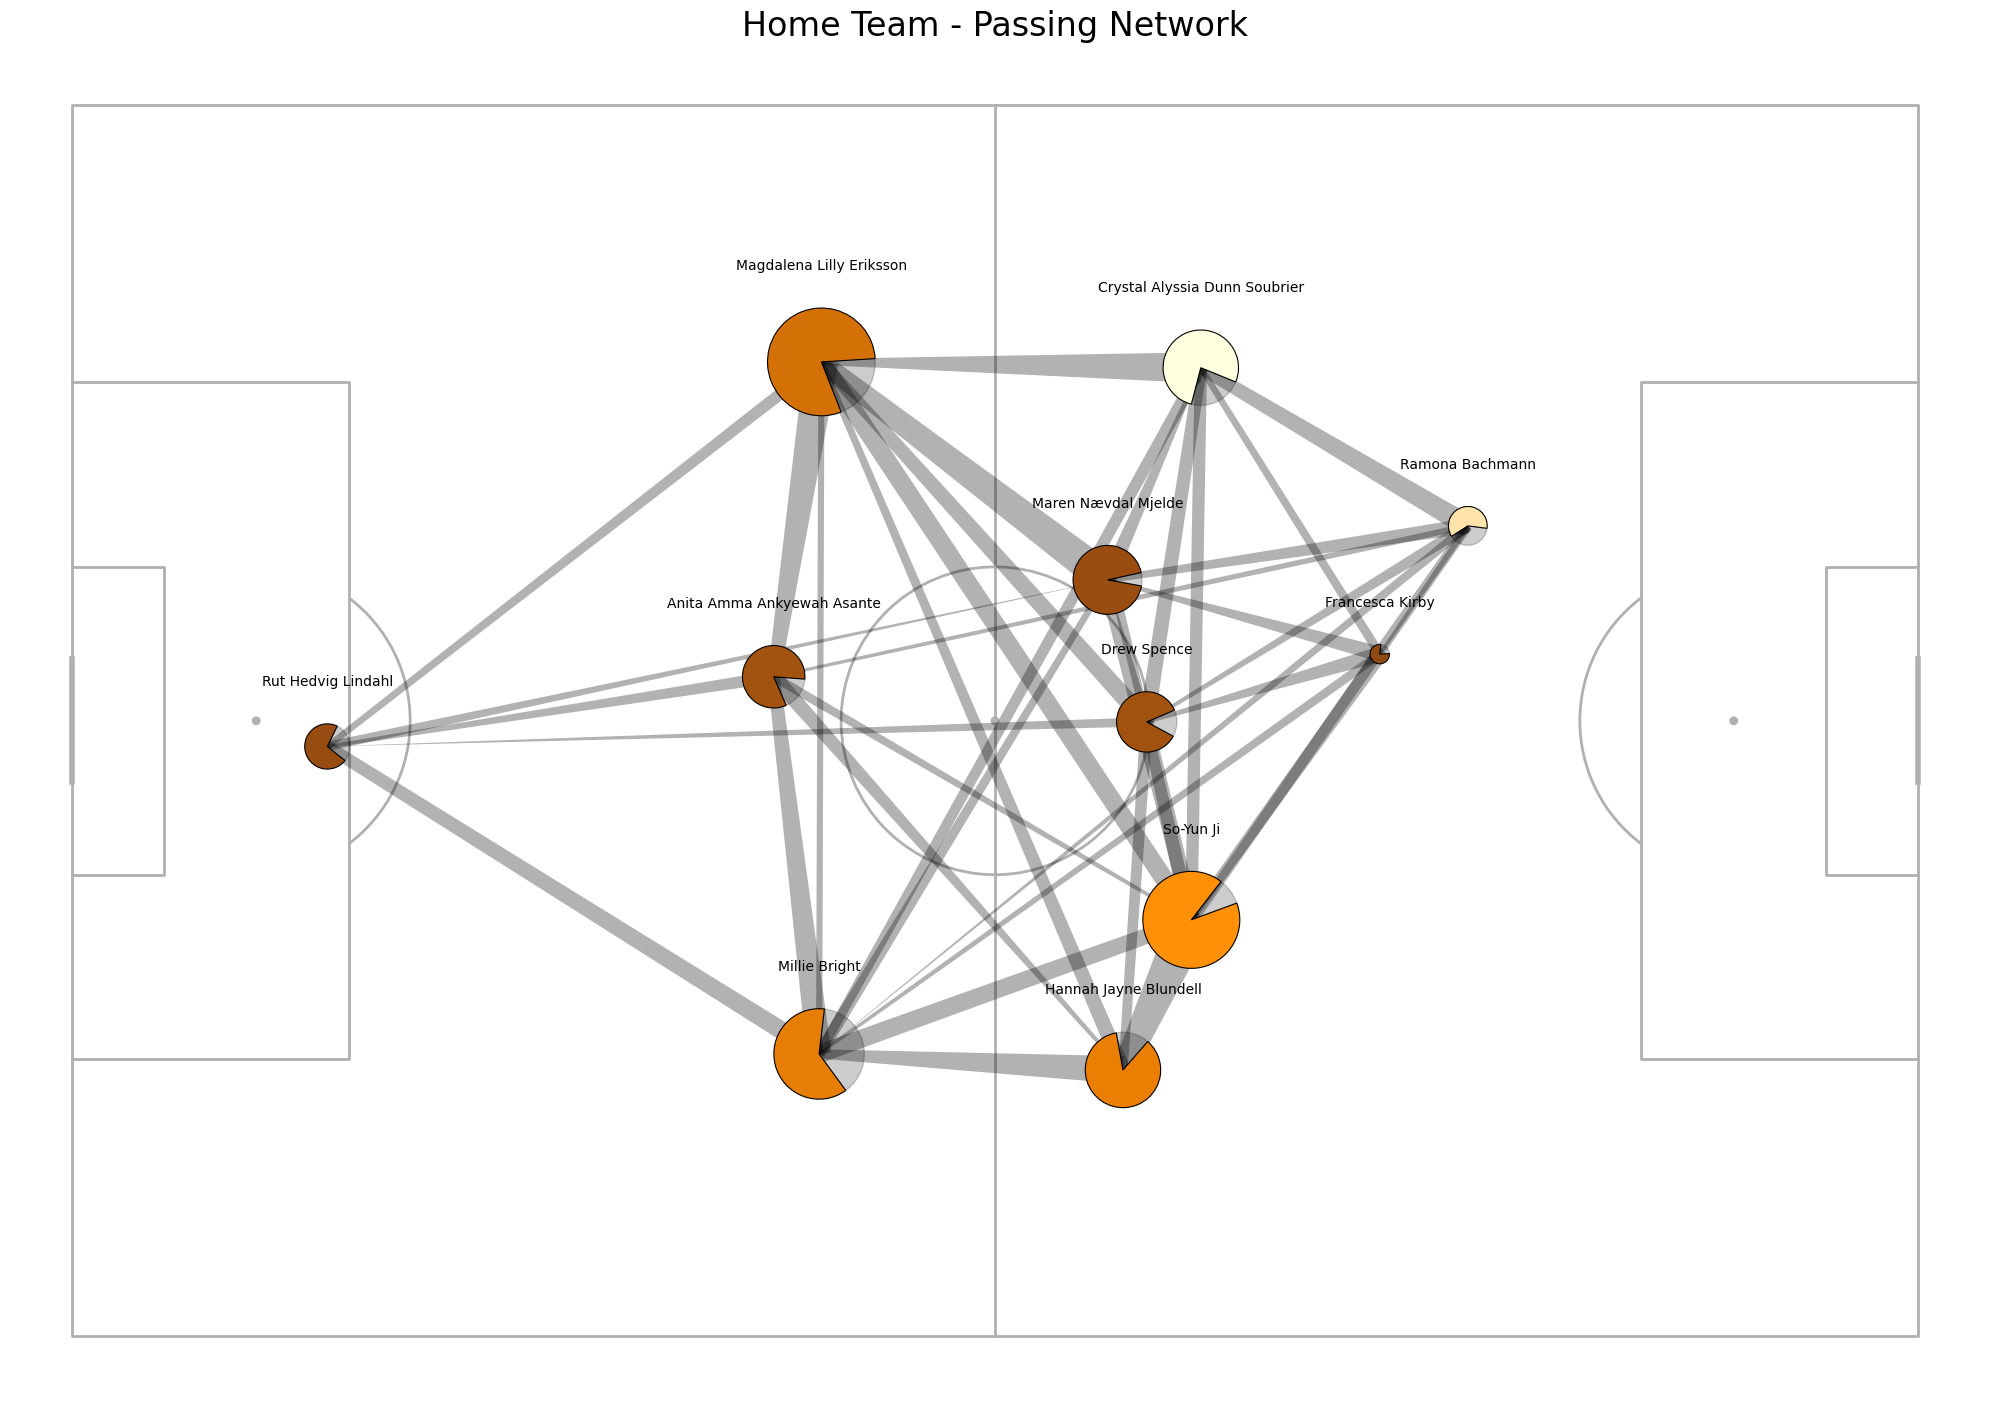

In [ ]:
match_id = 7298

base_path ="path/to/statsbomb_open_data/data"

df_clean_passes = prepare_filtered_passes(base_path, match_id)
network_schema = get_passing_network_schema(df_clean_passes)
plot_passing_network(network_schema)